# Combining SHAP and GradCAM

# Imports

In [1]:
import scipy
import numpy as np
!pip install tensorflow==2.15.0
import tensorflow as tf
!pip install shap==0.46.0
import shap
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import zoom
from scipy.signal import find_peaks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      

2024-10-29 10:32:30.393542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 10:32:30.393633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 10:32:30.395957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.3 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.7
    Uninstalling slicer-0.0.7:
      Successfully uninstalled slicer-0.0.7
  Attempting uninstall: shap
    Found existing installation: shap 0.44.1
    Uninstalling shap-0.44.1:
      Successfully uninstalled shap-0.44.1


# Load pre-trained model

In [2]:
print("Loading pre-trained model...")
model = load_model('/kaggle/input/6-data-for-explainableai/baseline_model.h5', compile=False)
# grad_model = load_model('/kaggle/input/6-data-for-explainableai/grad_model.h5', compile=False)
print("Model loaded successfully.")

Loading pre-trained model...
Model loaded successfully.


# Load or generate some sample data

In [20]:
data_test = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_test.csv')
data_train = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_train.csv')
data_val = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_val.csv')

labels_test = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_test.csv')
labels_train = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_train.csv')
labels_val = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_val.csv')

# This class is a customer data generator 
# It's purpose is to load, preprocess and supply data in batches during training
# It's there because it is inefficient to load large datasets at once
    
class ECG_DataGen(tf.keras.utils.Sequence):    
# Contructor - Takes a list of ECG files and labels, batch size (number of samples ), sample length (number of data points in each ECG signal), and an option to shuffle the data. 
    def __init__(self, df_files, df_labels, data_col, batch_size, sample_len, shuffle=True):
        #self is an instance of the class #it should be passed as first parameter in all methods
        
        self.df_files = df_files.copy()
        self.df_labels = df_labels.copy()
        self.data_col = data_col
        self.n_samples = len(self.df_files)
        self.sample_len = sample_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __len__(self):
        return self.n_samples // self.batch_size
    
#     applies low pass filter
    def low_pass_filter(self, voltages, window_size):
        """Applies a moving average low-pass filter to a 1D array of voltages."""
        # Create a windowed version of the array
        window = np.ones(window_size) / window_size
        filtered_voltages = np.convolve(voltages, window, mode='same')
        return filtered_voltages
    
#    normalizes data and apply low pass filter
    def scale(self, array):
        # Replace NaN values with 0.0
        array = np.nan_to_num(array, nan=0.0)
        
        #apply low pass filter
        array = self.low_pass_filter(array, window_size=100)

        # normalizing
        a_min = np.min(array)
        a_max = np.max(array)
        if a_max - a_min == 0:
            return np.zeros_like(array).reshape((-1, 1))
        return np.array((array - a_min) / (a_max - a_min))
       
#   TO BE SEARCHED  -  loads, preprocesses (filters and normalizes), and formats the data in chunks (batches) and returns it to the model.    
    def __getitem__(self, index):
        batch_leads = np.zeros((self.batch_size, self.sample_len, 12)) #create array with shape 128, 5000, 12
        batch_labels = np.zeros((self.batch_size, len(self.df_labels.columns))) 

        for i in range(index*self.batch_size, (index+1)*self.batch_size):

            # load the ECG signals
            leads = scipy.io.loadmat(self.df_files.at[i, self.data_col])['val'] #loadmat() is a function to load matlab files #self.df_files.at[i, self.data_col] is the file path
            
            for j, lead_data in enumerate(leads): #iterate through 12 leads
                #preprocess data (normalize, filter)
                scaled_lead_data = self.scale(lead_data)
                
                batch_leads[i - index*self.batch_size, :, j] = scaled_lead_data.reshape((-1,))
            batch_labels[i - index*self.batch_size] = self.df_labels.loc[i].values

        return batch_leads, batch_labels

    #  called at the end of every training epoch to shuffle data after every epoch
    def on_epoch_end(self):
        if self.shuffle: 
            shuffle_idx = np.random.choice(range(self.n_samples), size=self.n_samples, replace=False)
            self.df_files = self.df_files.iloc[shuffle_idx].reset_index(drop=True)
            self.df_labels = self.df_labels.iloc[shuffle_idx].reset_index(drop=True)
            
            
data_col = 'ecg_filename'
sample_len = 5000
batch_size= 1

# Create data generators (Objects from ECG_DataGen class)
# These generators do not store the data themselves; instead, they load, preprocess, and return batches of ECG data and corresponding labels during model training or evaluation.
train_gen = ECG_DataGen(data_train, labels_train, data_col, batch_size, sample_len)
val_gen = ECG_DataGen(data_val, labels_val, data_col, batch_size, sample_len)
test_gen = ECG_DataGen(data_test, labels_test, data_col, len(data_test), sample_len)

# SHAP DeepExplainer Initialization

In [19]:
# Extract a batch of data
X, _ = train_gen.__getitem__(0)  # Get the first batch
print(f"ECG data loaded successfully with shape: {X.shape}")

# Select a subset of the data for explanation
print("Selecting a subset of the data for explanation...")
X_sample = X[:10]  # Take first 10 samples as an example
print(f"Subset selected with shape: {X_sample.shape}")

ECG data loaded successfully with shape: (128, 5000, 12)
Selecting a subset of the data for explanation...
Subset selected with shape: (10, 5000, 12)


In [21]:
first_instance = ASMI
first_instance.shape

(1, 5000, 12)

In [22]:
print("Initializing SHAP DeepExplainer...")
explainer_shap = shap.DeepExplainer(model, X_sample)
shap_values = explainer_shap.shap_values(first_instance)  # Explain the first instance
print("SHAP explanation completed.")

Initializing SHAP DeepExplainer...


/opt/conda/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


SHAP explanation completed.


# GradCAM Implementation

In [23]:
def get_gradcam_heatmap(model, input_data, class_index):
    print("Input data shape:", input_data.shape)
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('conv1d').output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_data)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    print('shape of grads: ', grads.shape)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Compute GradCAM for a specific class
class_index = 19
heatmap = get_gradcam_heatmap(model, first_instance, class_index)
print("GradCAM heatmap generated with shape: ", heatmap.shape)

Input data shape: (1, 5000, 12)
shape of grads:  (1, 4998, 32)
GradCAM heatmap generated with shape:  (4998,)


# Plotting SHAP and GradCAM Results

## Method 1 - Plot ECG, SHAP and Heat map seperately

Generating unique interpretability plot using SHAP and GradCAM...


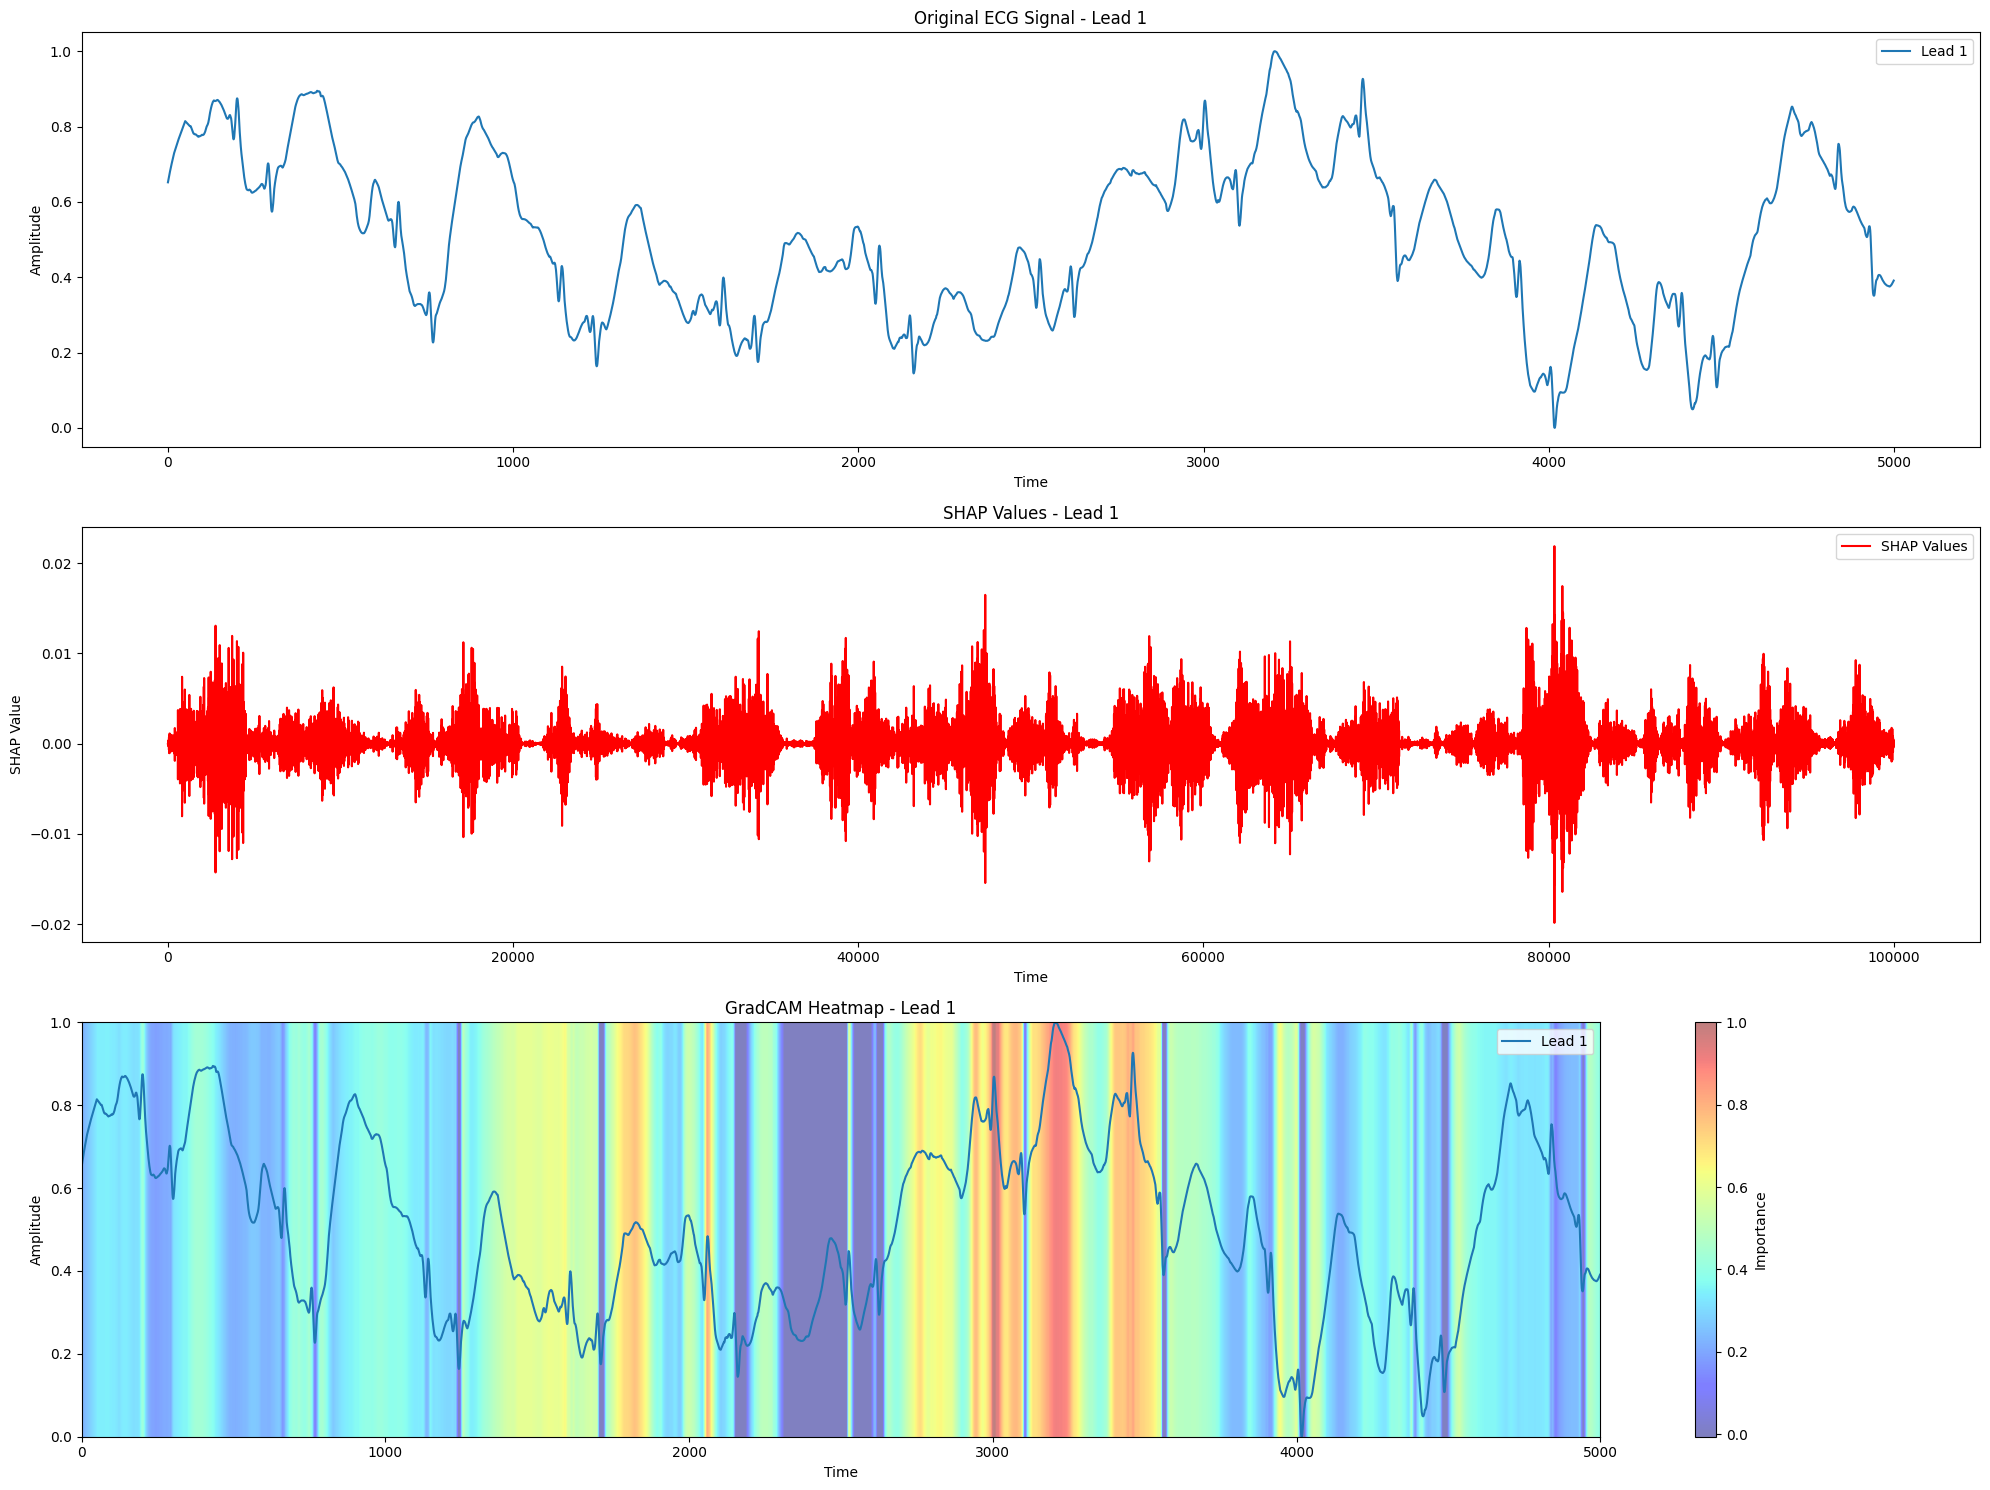

Combined interpretability plot generated.


In [17]:
# Unique Combined Interpretability Plot
print("Generating unique interpretability plot using SHAP and GradCAM...")
plt.figure(figsize=(20, 15))

# Plot the ECG signal
plt.subplot(3, 1, 1)
ecq_signal = X_sample[0, :, 0]
plt.plot(ecq_signal, label='Lead 1')
plt.title('Original ECG Signal - Lead 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# Plot SHAP values separately
plt.subplot(3, 1, 2)
shap_values_lead1 = shap_values[0][:, 0].flatten()  # Shape (5000,)
plt.plot(shap_values_lead1, color='red', label='SHAP Values')
plt.title('SHAP Values - Lead 1')
plt.xlabel('Time')
plt.ylabel('SHAP Value')
plt.legend()

# Plot GradCAM heatmap separately
plt.subplot(3, 1, 3)
heatmap_resized = zoom(heatmap, (5000 / heatmap.shape[0],))  # Shape (5000,)
heatmap_resized = heatmap_resized.flatten()  # Ensure both arrays are 1D
plt.plot(ecq_signal, label='Lead 1')
plt.imshow(np.expand_dims(heatmap_resized, axis=0), aspect='auto', cmap='jet', alpha=0.5, extent=[0, len(ecq_signal), np.min(ecq_signal), np.max(ecq_signal)])
plt.title('GradCAM Heatmap - Lead 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.colorbar(label='Importance')
plt.legend()

plt.tight_layout()
plt.show()
print("Combined interpretability plot generated.")

## Method 2 - Plot ECG and Combination of SHAP and Heatmap (but distinction is not clear)

Generating unique interpretability plot using SHAP and GradCAM...


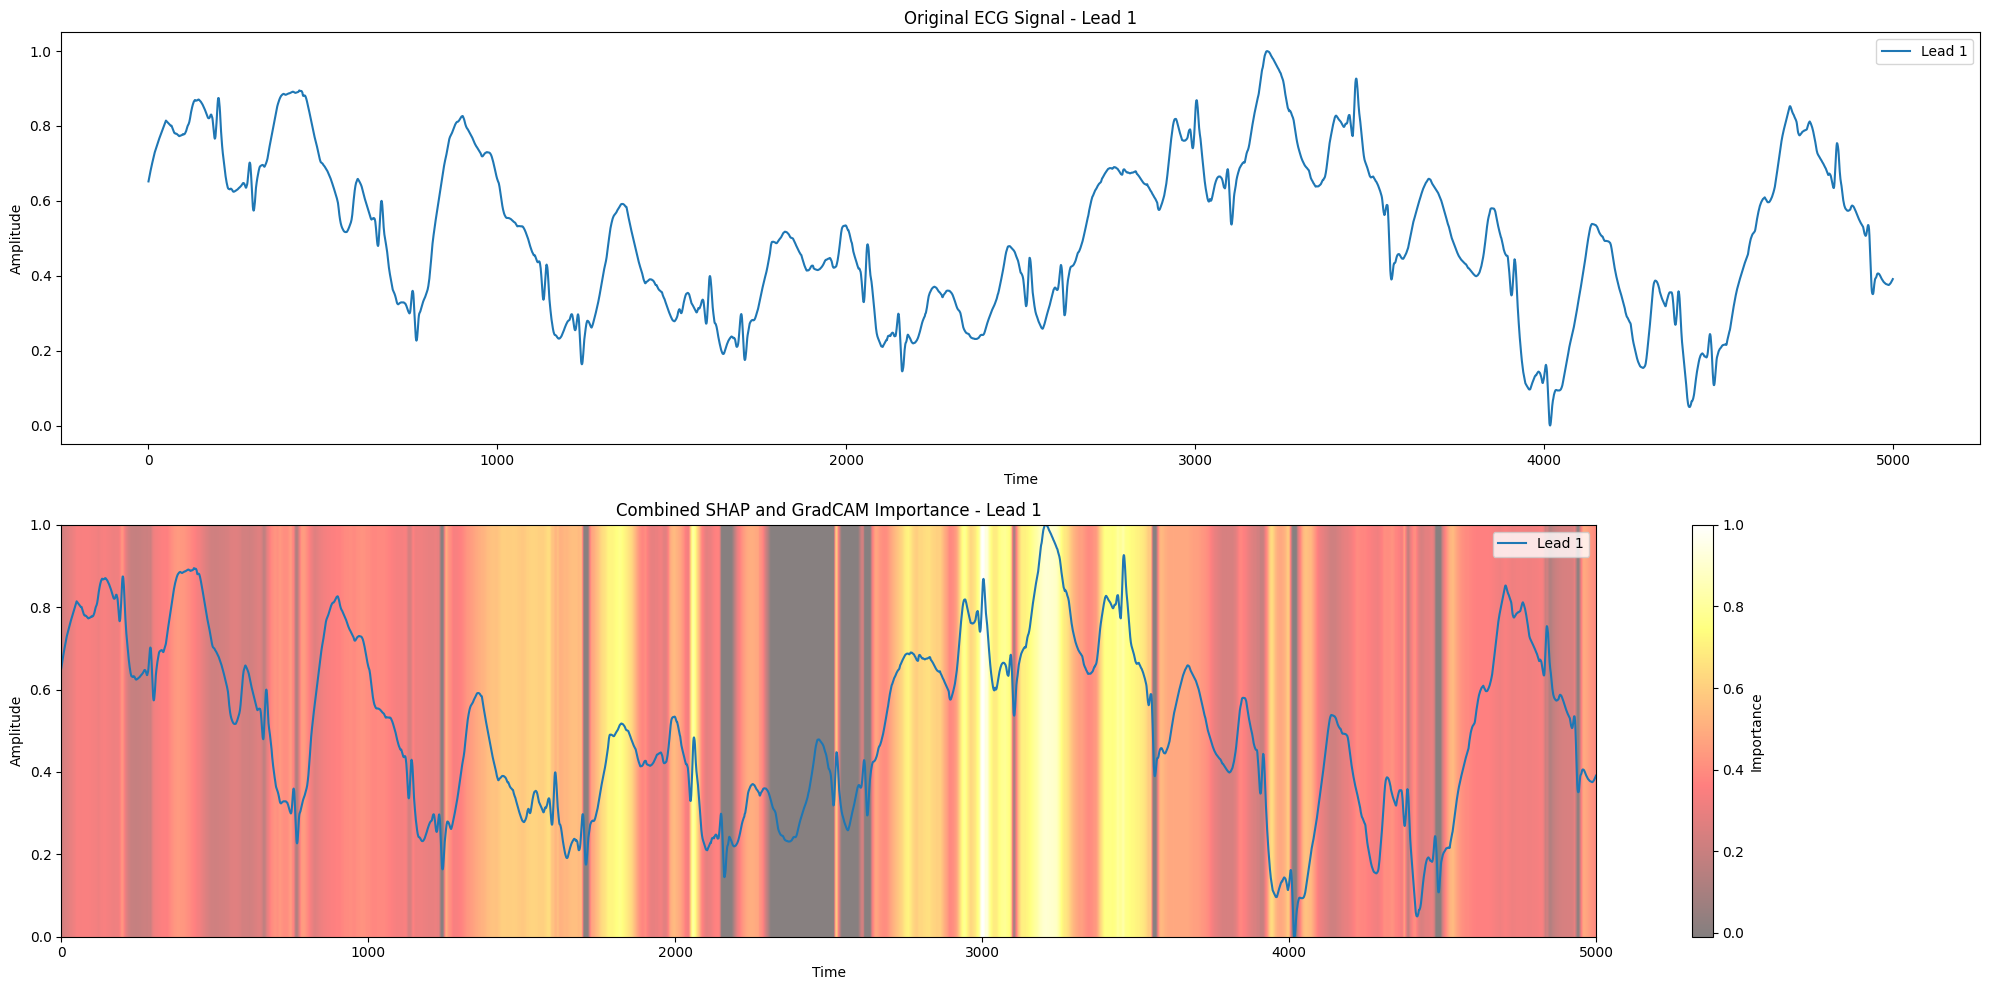

Combined interpretability plot generated.


In [16]:
# Unique Combined Interpretability Plot
print("Generating unique interpretability plot using SHAP and GradCAM...")
plt.figure(figsize=(20, 10))

# Plot the ECG signal
plt.subplot(2, 1, 1)
ecq_signal = X_sample[0, :, 0]
plt.plot(ecq_signal, label='Lead 1')
plt.title('Original ECG Signal - Lead 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# Combine SHAP and GradCAM to Highlight Important Regions
plt.subplot(2, 1, 2)
shap_values_lead1 = shap_values[0][:, 0].flatten()  # Shape (5000,)  # Shape (5000,)
heatmap_resized = zoom(heatmap, (5000 / heatmap.shape[0],))  # Shape (5000,)
heatmap_resized = heatmap_resized.flatten()  # Ensure both arrays are 1D
combined_importance = shap_values_lead1[:len(heatmap_resized)] + heatmap_resized
plt.plot(ecq_signal, label='Lead 1')
plt.imshow(np.expand_dims(combined_importance, axis=0), aspect='auto', cmap='hot', alpha=0.5, extent=[0, len(ecq_signal), np.min(ecq_signal), np.max(ecq_signal)])
plt.title('Combined SHAP and GradCAM Importance - Lead 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.colorbar(label='Importance')
plt.legend()

plt.tight_layout()
plt.show()
print("Combined interpretability plot generated.")


## Method 3 - Plot points which are common to both SHAP and Heatmap in top X percentage

In [29]:
X_sample[0, :, 0].shape

(5000,)

In [30]:
first_instance.shape

(1, 5000, 12)

### Same as original - with different ECG

In [36]:
percentage = 50
lead = 8
scale = 0.25

def compareECGAgainstFocus(ecg = [], disease = 'disease', lead = 0, percentage = 80, scale = 1):
    first_instance = ecg
    # Novel Combined Interpretability Plot
    print("Generating novel combined interpretability plot using SHAP and GradCAM...")
    plt.figure(figsize=(20*scale, 15*scale))

    # Plot the ECG signal
    plt.subplot(2, 1, 1)
    ecq_signal = first_instance[0, :, lead]
    plt.plot(ecq_signal, label=lead_mapping[lead])
    plt.title(f'Original ECG Signal - {lead_mapping[lead]} - {disease}')
    plt.xlabel('Datapoints')
    plt.ylabel('Amplitude')
    plt.legend()

    # Plot Combined SHAP and GradCAM Importance
    plt.subplot(2, 1, 2)
    shap_values_lead1 = shap_values[0][:, 0, class_index].flatten()  # Extract SHAP values for the specific class (5000,)
    heatmap_resized = zoom(heatmap, (5000 / heatmap.shape[0],))  # Shape (5000,)
    combined_importance = shap_values_lead1[:len(heatmap_resized)] + heatmap_resized

    # Highlight regions where both SHAP and GradCAM agree
    agreement_mask = (shap_values_lead1 > np.percentile(shap_values_lead1, percentage)) & (heatmap_resized > np.percentile(heatmap_resized, percentage))
    plt.plot(ecq_signal, label=lead_mapping[lead])
    # plt.imshow(np.expand_dims(combined_importance, axis=0), aspect='auto', cmap='hot', alpha=0.5, extent=[0, len(ecq_signal), np.min(ecq_signal), np.max(ecq_signal)])
    plt.scatter(np.where(agreement_mask)[0], [ecq_signal[i] for i in np.where(agreement_mask)[0]], color='red', s=15, label='High Agreement Regions')

    plt.title(f'Combined SHAP and GradCAM Importance - {lead_mapping[lead]}')
    plt.xlabel('Datapoints')
    plt.ylabel('Amplitude')
    # plt.colorbar(label='Importance')
    plt.legend()

    plt.tight_layout()
    plt.show()
    print("Novel combined interpretability plot generated.")
    
    
def compareSHAPAgainstSHAPandGradCAM(ecg = [], disease = 'disease', lead = 0, percentage = 80, scale = 1):
    first_instance = ecg
    # Novel Combined Interpretability Plot
    print("Generating novel combined interpretability plot using SHAP and GradCAM...")
    plt.figure(figsize=(20*scale, 15*scale))

    # Plot the ECG signal
    plt.subplot(2, 1, 1)
    ecq_signal = first_instance[0, :, lead]
    shap_values_lead1 = shap_values[0][:, 0, class_index].flatten()
    agreement_mask = (shap_values_lead1 > np.percentile(shap_values_lead1, percentage))
    plt.plot(ecq_signal, label=lead_mapping[lead])
    plt.scatter(np.where(agreement_mask)[0], [ecq_signal[i] for i in np.where(agreement_mask)[0]], color='red', s=15, label='High Agreement Regions')
    plt.title(f'SHAP Importance - {lead_mapping[lead]} - {disease}')
    plt.xlabel('Datapoints')
    plt.ylabel('Amplitude')
    plt.legend()

    # Plot Combined SHAP and GradCAM Importance
    plt.subplot(2, 1, 2)
    shap_values_lead1 = shap_values[0][:, 0, class_index].flatten()  # Extract SHAP values for the specific class (5000,)
    heatmap_resized = zoom(heatmap, (5000 / heatmap.shape[0],))  # Shape (5000,)
    combined_importance = shap_values_lead1[:len(heatmap_resized)] + heatmap_resized

    # Highlight regions where both SHAP and GradCAM agree
    agreement_mask = (shap_values_lead1 > np.percentile(shap_values_lead1, percentage)) & (heatmap_resized > np.percentile(heatmap_resized, percentage))
    plt.plot(ecq_signal, label=lead_mapping[lead])
    # plt.imshow(np.expand_dims(combined_importance, axis=0), aspect='auto', cmap='hot', alpha=0.5, extent=[0, len(ecq_signal), np.min(ecq_signal), np.max(ecq_signal)])
    plt.scatter(np.where(agreement_mask)[0], [ecq_signal[i] for i in np.where(agreement_mask)[0]], color='red', s=15, label='High Agreement Regions')

    plt.title(f'Combined SHAP and GradCAM Importance - {lead_mapping[lead]}')
    plt.xlabel('Datapoints')
    plt.ylabel('Amplitude')
    # plt.colorbar(label='Importance')
    plt.legend()

    plt.tight_layout()
    plt.show()
    print("Novel combined interpretability plot generated.")


#### Initial attempt

Generating novel combined interpretability plot using SHAP and GradCAM...


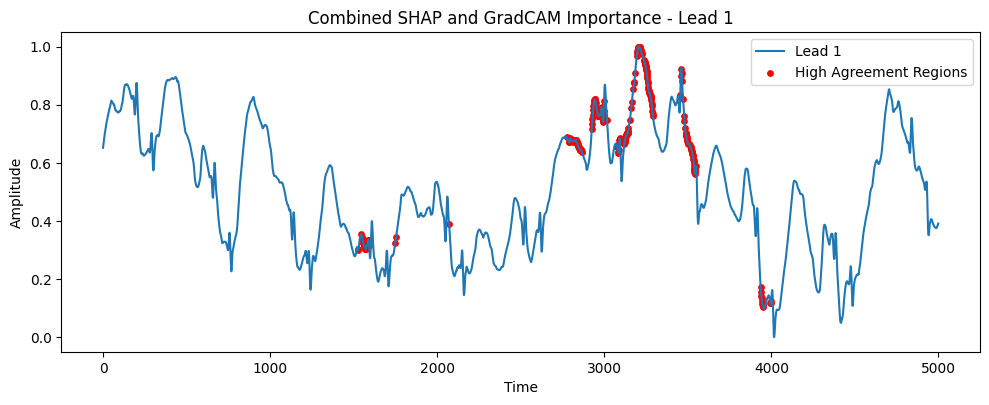

Novel combined interpretability plot generated.


In [ ]:
percentage = 80
scale = 0.5
# Novel Combined Interpretability Plot
print("Generating novel combined interpretability plot using SHAP and GradCAM...")
plt.figure(figsize=(20*scale, 15*scale))

# Plot the ECG signal
# plt.subplot(2, 1, 1)
ecq_signal = X_sample[0, :, 0]
# plt.plot(ecq_signal, label='Lead 1')
# plt.title('Original ECG Signal - Lead 1')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.legend()

# Plot Combined SHAP and GradCAM Importance
plt.subplot(2, 1, 2)
shap_values_lead1 = shap_values[0][:, 0, class_index].flatten()  # Extract SHAP values for the specific class (5000,)
heatmap_resized = zoom(heatmap, (5000 / heatmap.shape[0],))  # Shape (5000,)
combined_importance = shap_values_lead1[:len(heatmap_resized)] + heatmap_resized

# Highlight regions where both SHAP and GradCAM agree
agreement_mask = (shap_values_lead1 > np.percentile(shap_values_lead1, percentage)) & (heatmap_resized > np.percentile(heatmap_resized, percentage))
plt.plot(ecq_signal, label='Lead 1')
# plt.imshow(np.expand_dims(combined_importance, axis=0), aspect='auto', cmap='hot', alpha=0.5, extent=[0, len(ecq_signal), np.min(ecq_signal), np.max(ecq_signal)])
plt.scatter(np.where(agreement_mask)[0], [ecq_signal[i] for i in np.where(agreement_mask)[0]], color='red', s=15, label='High Agreement Regions')

plt.title('Combined SHAP and GradCAM Importance - Lead 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
# plt.colorbar(label='Importance')
plt.legend()

plt.tight_layout()
plt.show()
print("Novel combined interpretability plot generated.")


In [ ]:
print('Combined importane shape: ', combined_importance.shape)
print('Shape of agreement_mask: ', agreement_mask.shape)
print('Shape of agreement regions: ', np.where(agreement_mask)[0].shape)

Combined importane shape:  (5000,)
Shape of agreement_mask:  (5000,)
Shape of agreement regions:  (290,)


#### ASMI

Generating novel combined interpretability plot using SHAP and GradCAM...


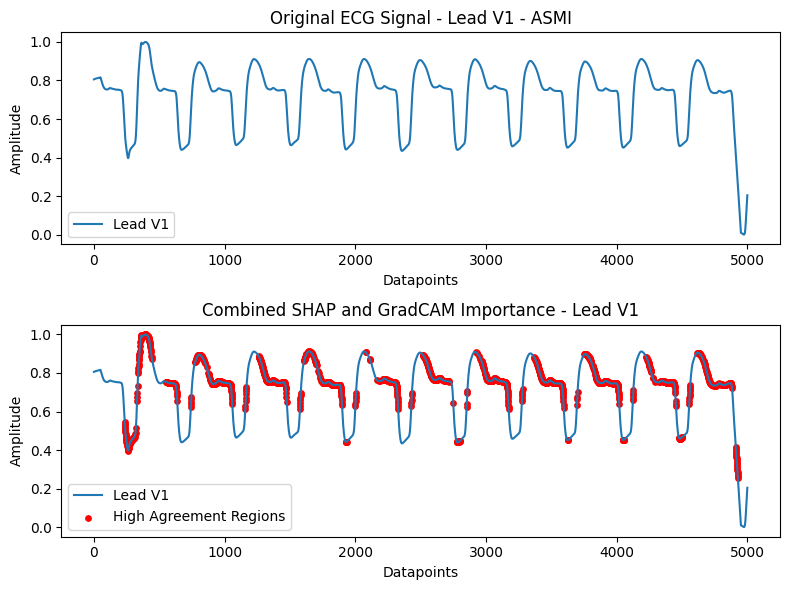

Novel combined interpretability plot generated.


In [26]:
shap_values = explainer_shap.shap_values(ASMI)
compareECGAgainstFocus(ecg = ASMI, disease = 'ASMI', lead = 6, percentage = 40, scale = 0.4)

#### LVH

Generating novel combined interpretability plot using SHAP and GradCAM...


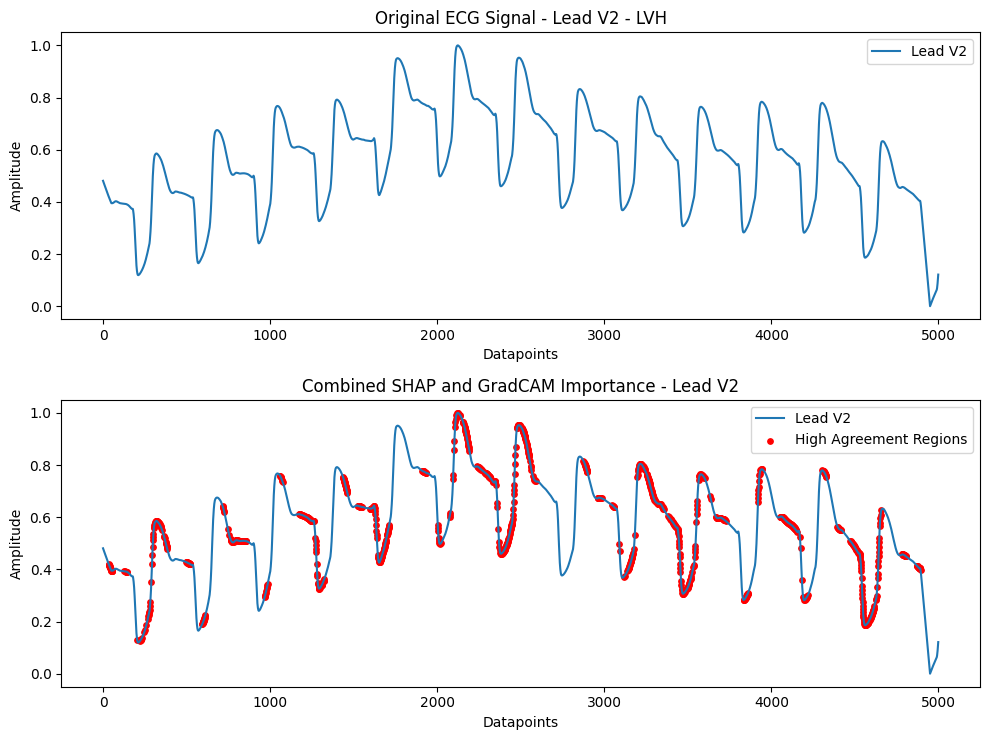

Novel combined interpretability plot generated.


In [74]:
shap_values = explainer_shap.shap_values(LVH)
compareECGAgainstFocus(ecg = LVH, disease = 'LVH', lead = 7, percentage = 50, scale = 0.5)

#### IMI - Comparing SHAP vs GradCAM and SHAP

Generating novel combined interpretability plot using SHAP and GradCAM...


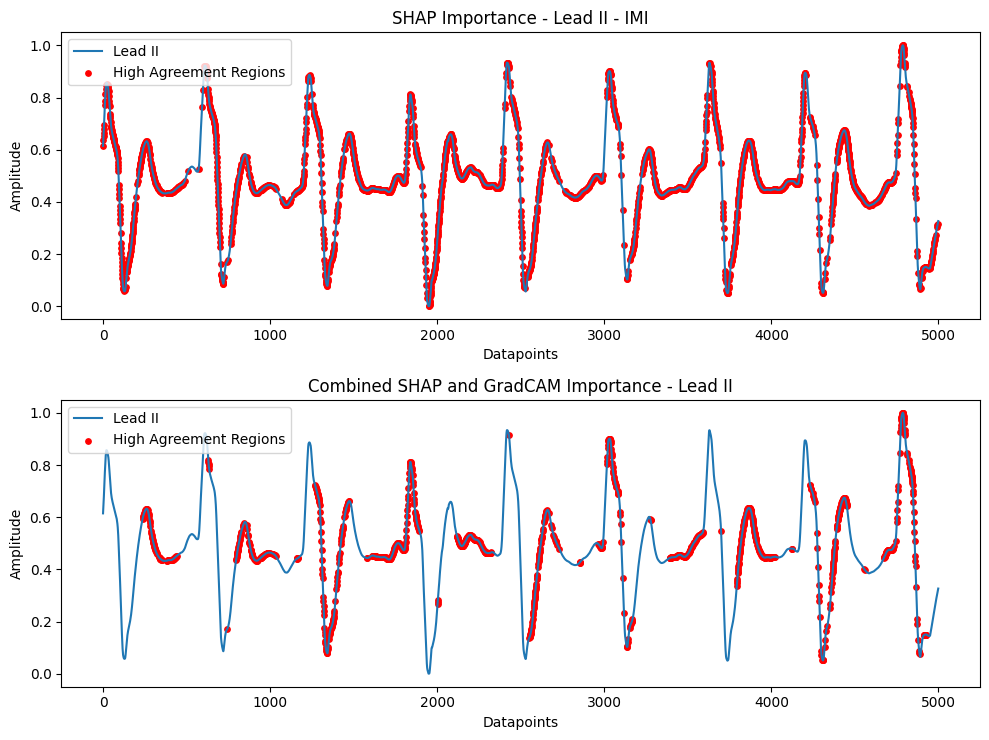

Novel combined interpretability plot generated.


In [37]:
shap_values = explainer_shap.shap_values(IMI)
compareSHAPAgainstSHAPandGradCAM(ecg = IMI, disease = 'IMI', lead = 1, percentage = 50, scale = 0.5)

Generating novel combined interpretability plot using SHAP and GradCAM...


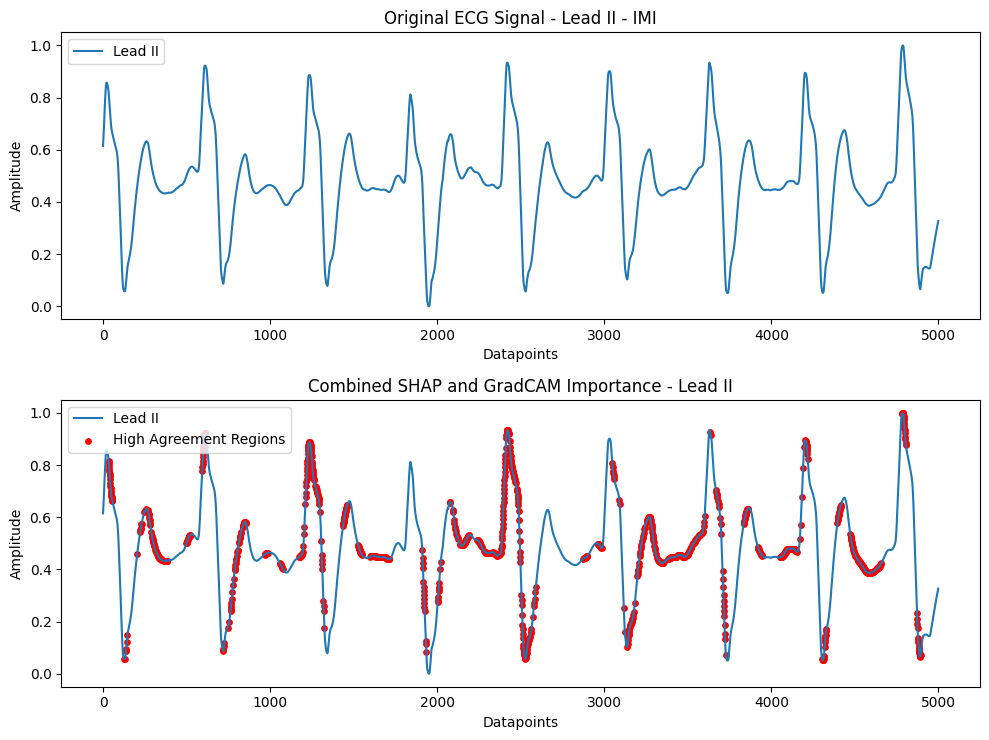

Novel combined interpretability plot generated.


In [81]:
shap_values = explainer_shap.shap_values(IMI)
compareECGAgainstFocus(ecg = IMI, disease = 'IMI', lead = 1, percentage = 50, scale = 0.5)

## Method 4 - Plot only waves patterns which are common to SHAP and Heatmap

In [69]:
X_sample[0, :, 0].shape

(5000,)

Generating novel combined interpretability plot using SHAP, GradCAM, and wave detection...


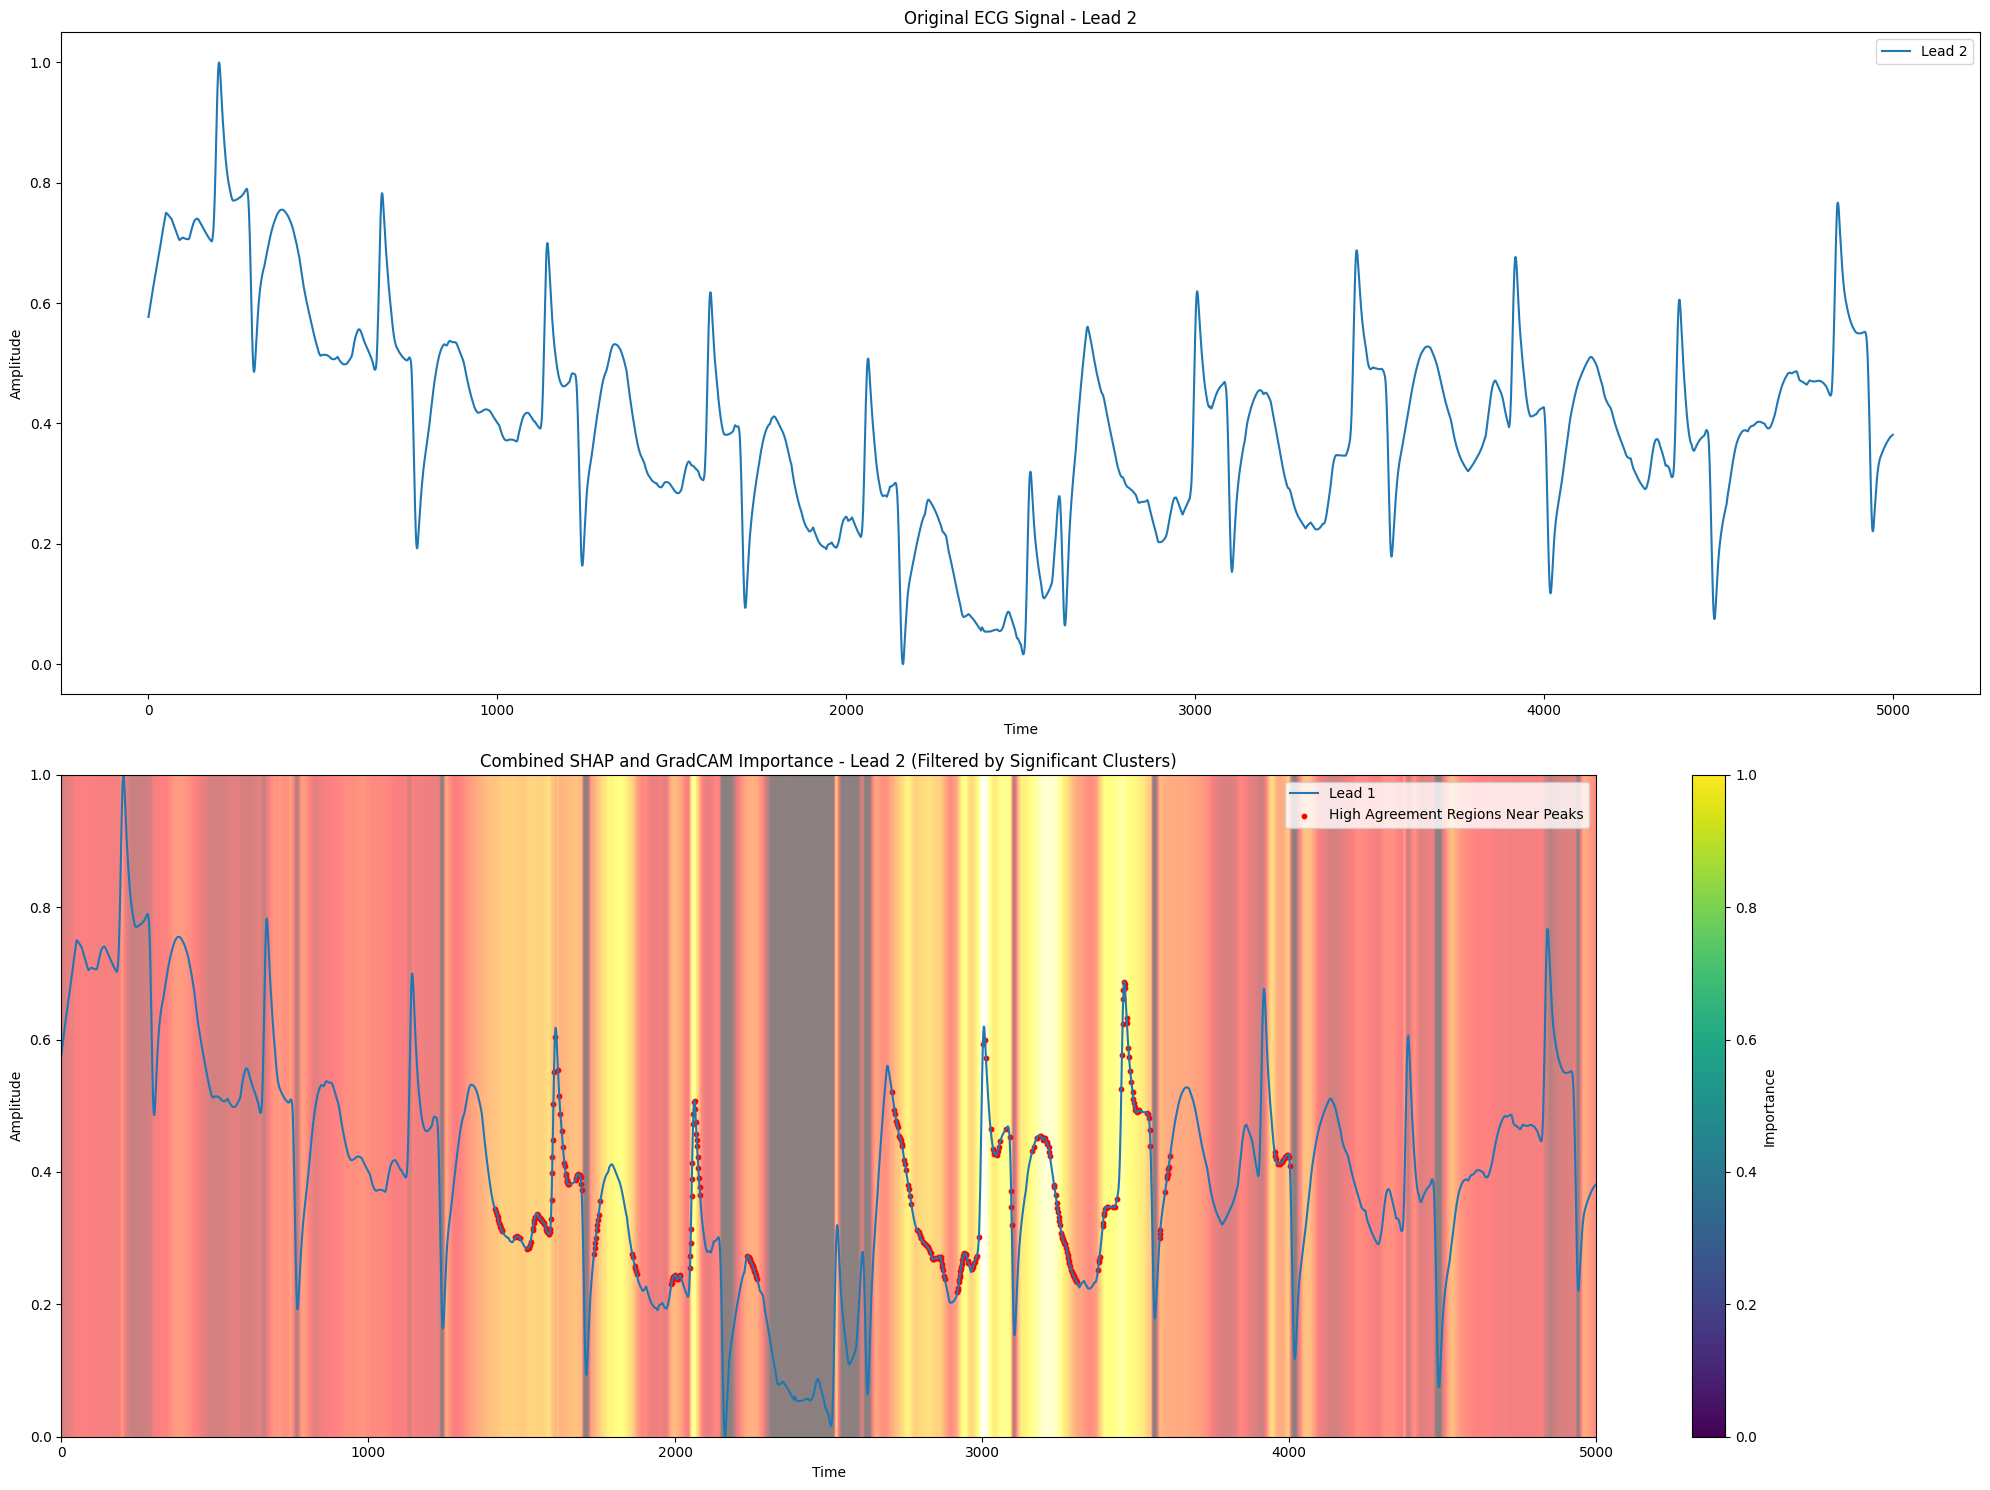

Novel combined interpretability plot with significant cluster filtering generated.


In [89]:
percentage = 70

window_size = 50  # Define the window size for clustering points
min_cluster_size = 5  # Define minimum number of points for a cluster to be considered significant

# Specify the lead to be plotted
lead_number = 1 # Change this value to select a different lead (0-11 for 12 leads)

# Novel Combined Interpretability Plot with Wave Detection
print("Generating novel combined interpretability plot using SHAP, GradCAM, and wave detection...")
plt.figure(figsize=(20, 15))

# Plot the ECG signal
plt.subplot(2, 1, 1)
ecq_signal = X_sample[0, :, lead_number]
plt.plot(ecq_signal, label=f'Lead {lead_number + 1}')
plt.title(f'Original ECG Signal - Lead {lead_number + 1}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# Detect peaks in the ECG signal to identify key wave points
peaks, _ = find_peaks(ecq_signal, height=0.5, distance=150)  # Adjust height and distance for better peak detection

# Plot Combined SHAP and GradCAM Importance
plt.subplot(2, 1, 2)
shap_values_lead = shap_values[0][:, lead_number, class_index].flatten()  # Extract SHAP values for the specific class (5000,)
heatmap_resized = zoom(heatmap, (5000 / heatmap.shape[0],))  # Shape (5000,)
combined_importance = shap_values_lead[:len(heatmap_resized)] + heatmap_resized

# Highlight regions where both SHAP and GradCAM agree, and also fall near detected peaks
agreement_mask = (shap_values_lead > np.percentile(shap_values_lead, percentage)) & (heatmap_resized > np.percentile(heatmap_resized, percentage))
filtered_agreement_clusters = []
current_cluster = []

for idx in np.where(agreement_mask)[0]:
    if not current_cluster or idx - current_cluster[-1] <= window_size:
        current_cluster.append(idx)
    else:
        if len(current_cluster) >= min_cluster_size:
            filtered_agreement_clusters.extend(current_cluster)
        current_cluster = [idx]

# Add the last cluster if it's significant
if len(current_cluster) >= min_cluster_size:
    filtered_agreement_clusters.extend(current_cluster)

plt.plot(ecq_signal, label='Lead 1')
plt.imshow(np.expand_dims(combined_importance, axis=0), aspect='auto', cmap='hot', alpha=0.5, extent=[0, len(ecq_signal), np.min(ecq_signal), np.max(ecq_signal)])
plt.scatter(filtered_agreement_clusters, [ecq_signal[i] for i in filtered_agreement_clusters], color='red', s=10, label='High Agreement Regions Near Peaks')

plt.title(f'Combined SHAP and GradCAM Importance - Lead {lead_number + 1} (Filtered by Significant Clusters)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.colorbar(label='Importance')
plt.legend()

plt.tight_layout()
plt.show()
print("Novel combined interpretability plot with significant cluster filtering generated.")

# PROOF

## Methods

In [ ]:
lead_mapping = {
    0: 'Lead I',
    1: 'Lead II',
    2:'Lead III',
    3:'Lead aVR',
    4:'Lead aVL',
    5:'Lead aVF',
    6:'Lead V1',
    7:'Lead V2',
    8:'Lead V3',
    9:'Lead V4',
    10:'Lead V5',
    11:'Lead V6',
}

def plotAll(ecg = []):
    plt.figure(figsize=(20, 15))

    for lead in range(12):
        plt.subplot(6, 2, lead + 1)

        # Get the ECG signal for this lead
        ecg_signal = ecg[0][:, lead]

        # Plot the ECG signal
        plt.plot(ecg_signal, color='blue')
        plt.title(lead_mapping[lead])
        plt.xlabel('Time points')
        plt.ylabel('ECG Signal')
        plt.legend()
    plt.figlegend(['ECG Signal'], loc='upper right', ncol=2)
    plt.tight_layout()
    plt.show()
    
def plot(ecg = [], lead = 0):
    plt.figure(figsize=(20, 6))

#     for lead in range(12):
#     plt.subplot(3, 4, lead + 1)

    # Get the ECG signal for this lead
    ecg_signal = ecg[0][:, lead]

    # Plot the ECG signal
    plt.plot(ecg_signal, color='blue')
    plt.title(lead_mapping[lead])
    plt.xlabel('Time points')
    plt.ylabel('ECG Signal')
    plt.legend()
    plt.figlegend(['ECG Signal'], loc='upper right', ncol=2)
    plt.tight_layout()
    plt.show()

## Compare Doc feature and SHAP+GradCAM Feature

### Record index

In [ ]:
# ECG Index finder
for i in range(1000, 2000):
    ECG, _ = train_gen.__getitem__(i)
    prediction = model.predict(ECG[:1])
    predicted_disease_index = np.argmax(prediction)
    disease = labels_train.columns[predicted_disease_index]
    if (disease == 'ASMI'):
        print(f'Predicted disease {i +1}:', disease)

### Load record

In [ ]:
ASMI, _ = train_gen.__getitem__(509)

SR, _ = train_gen.__getitem__(1)

LVH, _ = train_gen.__getitem__(622)

IMI, _ = train_gen.__getitem__(625)

1/1 [==============================] - 0s 23ms/step
Predicted disease: ASMI
Probability: 17.72569715976715


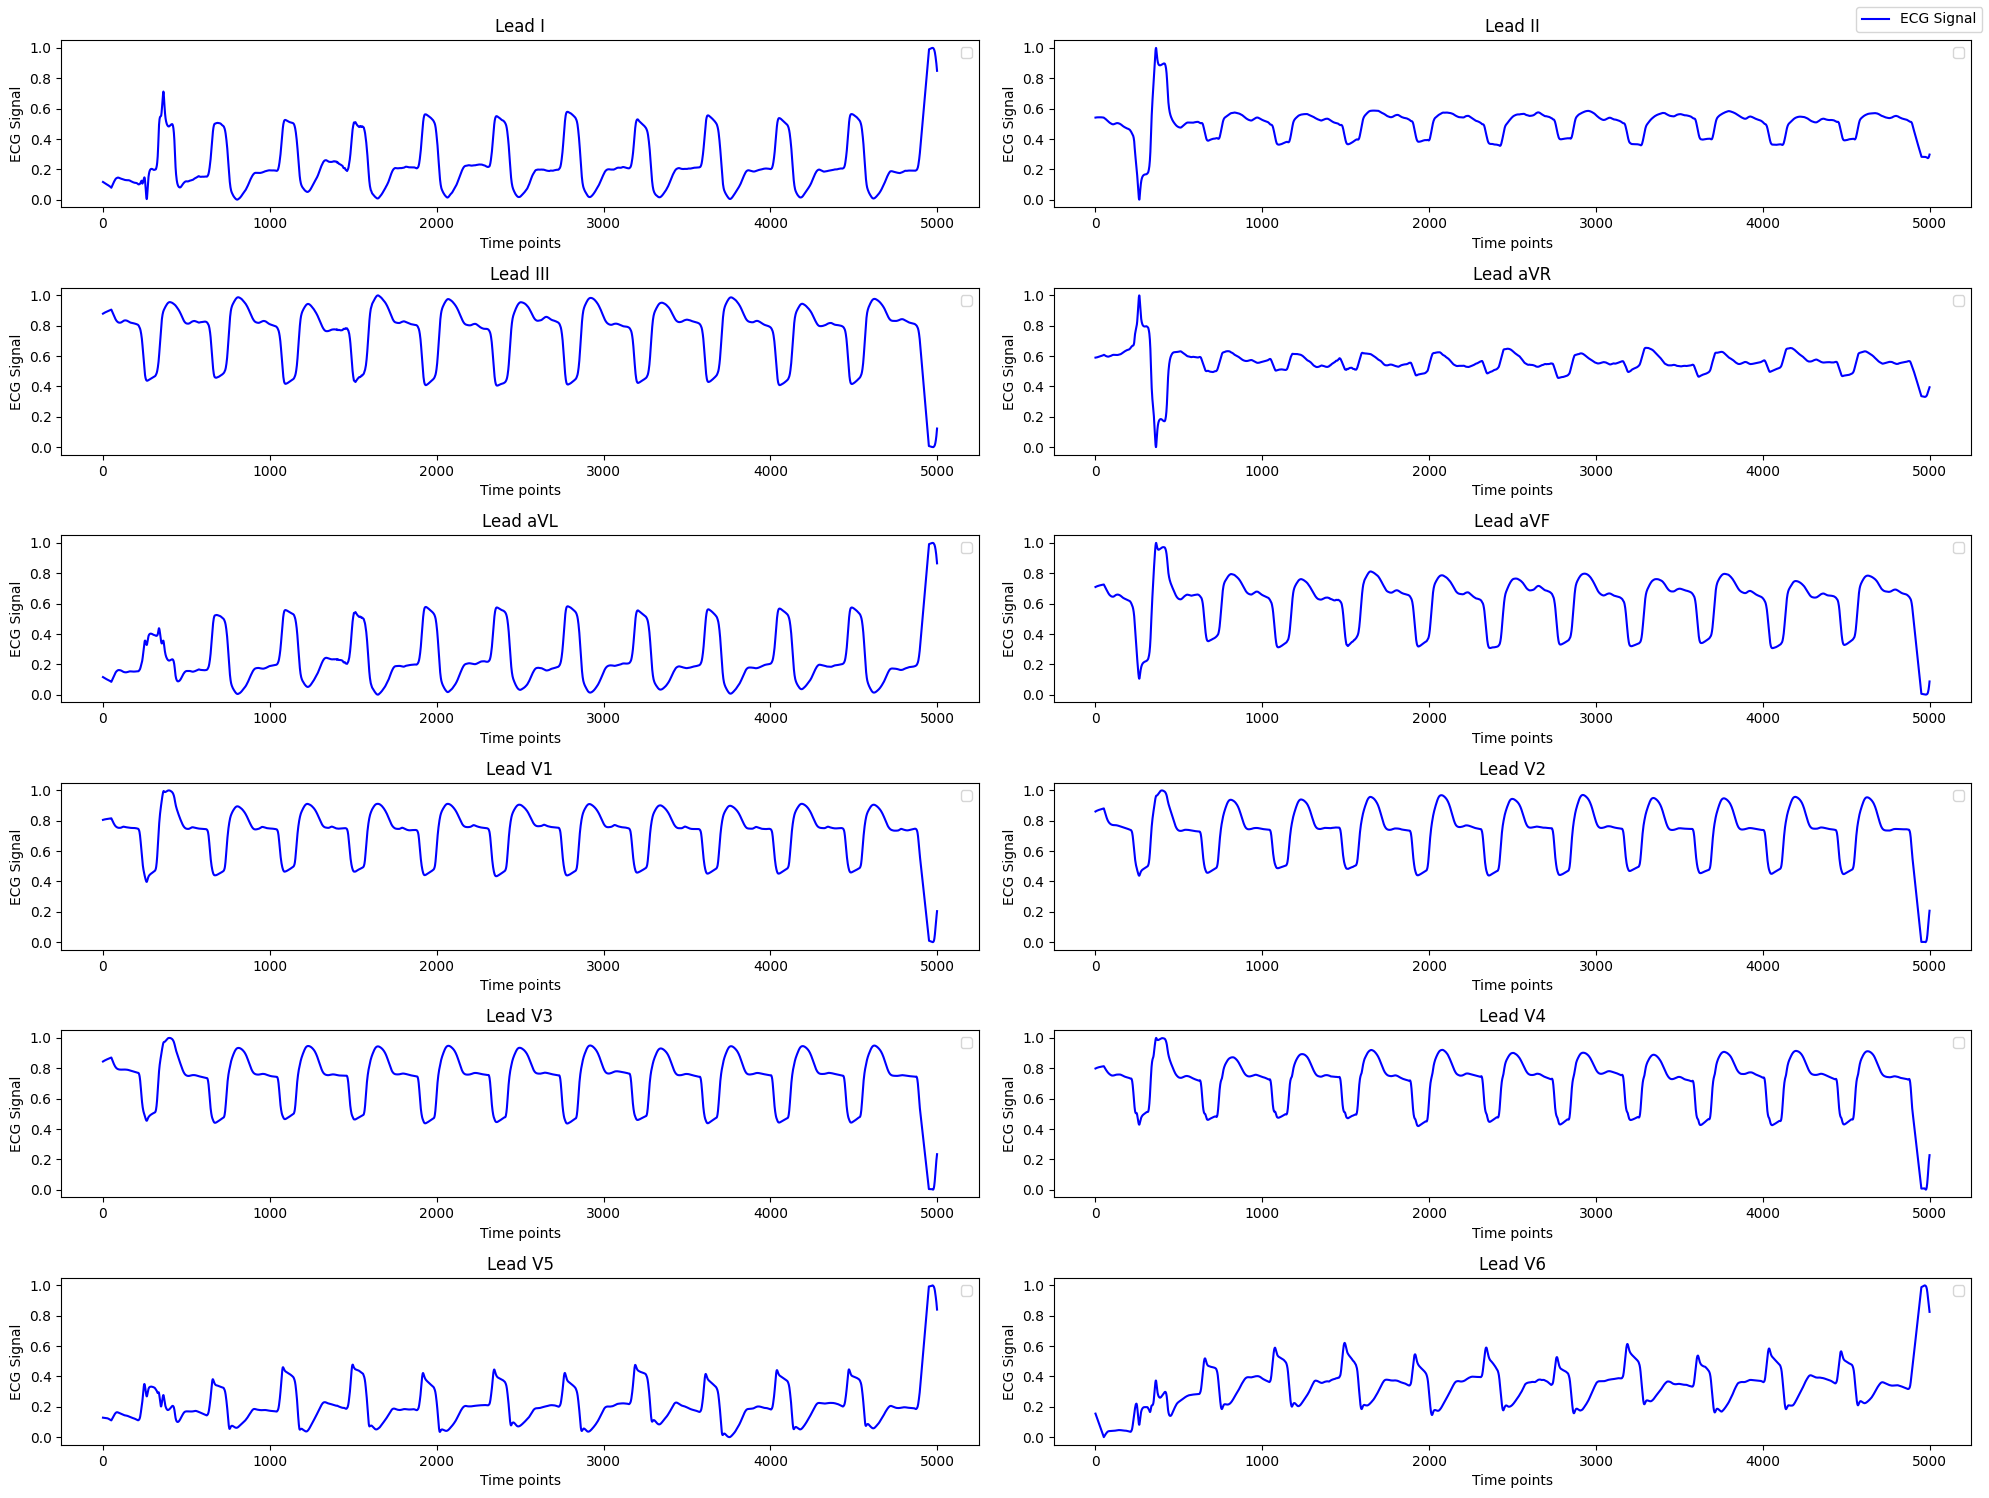

In [ ]:
ECG = ASMI

prediction = model.predict(ECG[:1])
predicted_disease_index = np.argmax(prediction)
disease = labels_train.columns[predicted_disease_index]
probability = np.max(prediction) * 100

print('Predicted disease:', disease)
print('Probability:', probability)

plotAll(ECG)

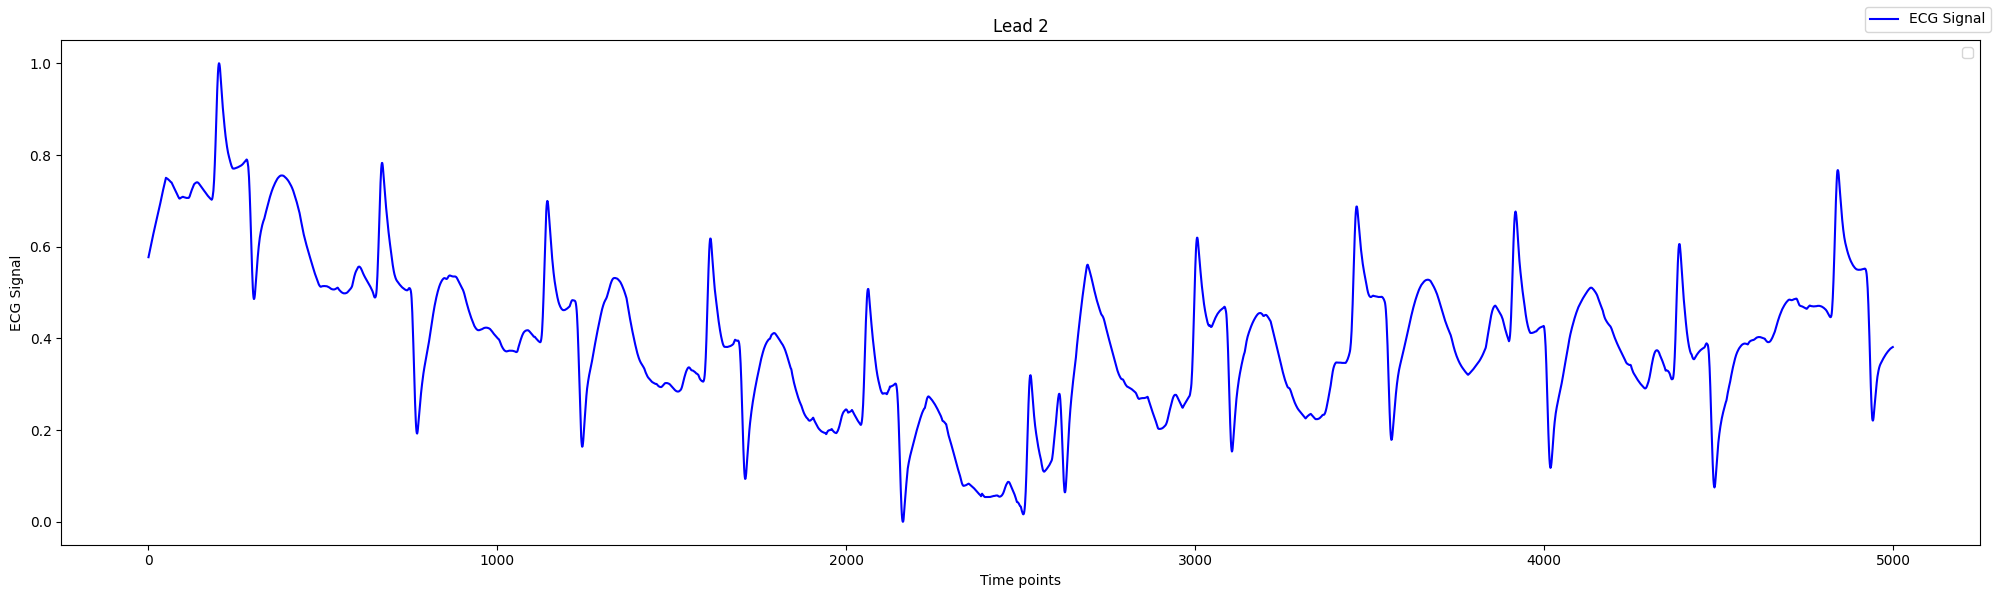

In [ ]:
plot(ECG, 1)